In [1]:
import time
import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV


                                          tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying
cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64


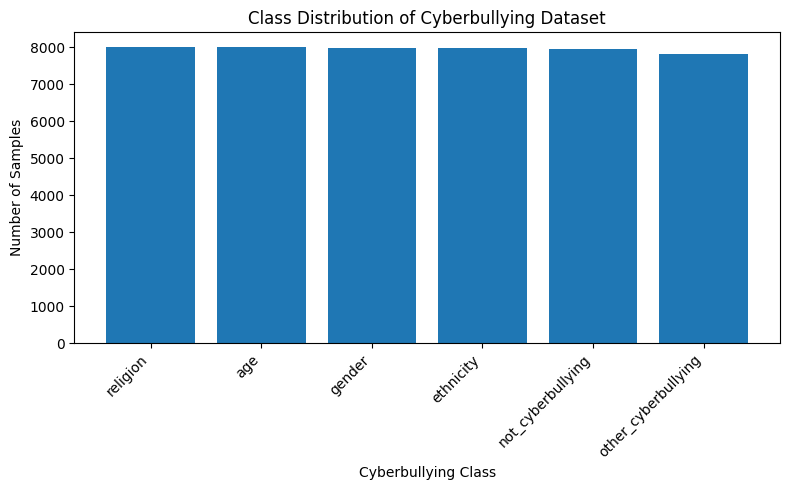

In [2]:
df = pd.read_csv("cyberbullying_tweets.csv")

# Basic cleanup
df = df.dropna(subset=["tweet_text", "cyberbullying_type"])

print(df.head())
print(df["cyberbullying_type"].value_counts())

import matplotlib.pyplot as plt

class_counts = df["cyberbullying_type"].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Cyberbullying Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution of Cyberbullying Dataset")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [3]:
#Encode Label
le = LabelEncoder()
df["label"] = le.fit_transform(df["cyberbullying_type"])

X = df["tweet_text"]
y = df["label"]

In [4]:
#Train / Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [5]:
#Classical ML model
models = {
    "LinearSVC": LinearSVC(max_iter=5000),
    "LogisticRegression": LogisticRegression(
        max_iter=2000, class_weight="balanced"
    ),
    "NaiveBayes": MultinomialNB(),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )
}

In [28]:
#Baseline Models
baseline_results = []
baseline_predictions = {}

for name, model in models.items():
    print(f"Baseline training: {name}")

    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=30000, ngram_range=(1,2))),
        ("clf", model)
    ])
    
    #Time training ONLY
    start = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start

    #Predict once
    y_pred = pipe.predict(X_test)
    #Store predictions
    baseline_predictions[name] = y_pred

#Baseline Models result
    baseline_results.append({
        "Model": name,
        "Stage": "Baseline",
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1_Macro": f1_score(y_test, y_pred, average="macro"),
        "F1_Weighted": f1_score(y_test, y_pred, average="weighted"),
        "Train_Time_sec": train_time
    })

Baseline training: LinearSVC
Baseline training: LogisticRegression
Baseline training: NaiveBayes
Baseline training: RandomForest


In [7]:
# # Containers for predictions and timing (shared across models)
# predictions = {}
# timings = {}

# # Grid Search Tuning
# from sklearn.model_selection import GridSearchCV

# tuned_results = []
# best_models = {}

# for name, model in models.items():
#     if name == "NaiveBayes":
#         param_grid = {
#             "tfidf__max_features": [10000, 30000],
#             "tfidf__ngram_range": [(1,1), (1,2)],
#             "clf__alpha": [0.1, 1.0]
#         }
#     elif name == "LogisticRegression":
#         param_grid = {
#             "tfidf__max_features": [10000, 30000],
#             "tfidf__ngram_range": [(1,1), (1,2)],
#             "clf__C": [0.1, 1, 10]
#         }
#     elif name == "LinearSVC":
#         param_grid = {
#             "tfidf__max_features": [10000, 30000],
#             "tfidf__ngram_range": [(1,1), (1,2)],
#             "clf__C": [0.1, 1, 10]
#         }
#     elif name == "RandomForest":
#         param_grid = {
#             "tfidf__max_features": [10000],
#             "tfidf__ngram_range": [(1,1)],
#             "clf__n_estimators": [100, 200],
#             "clf__max_depth": [None, 30]
#         }
#     else:
#         continue

#     pipe = Pipeline([
#         ("tfidf", TfidfVectorizer()),
#         ("clf", model)
#     ])

#     gs = GridSearchCV(
#         pipe,
#         param_grid,
#         scoring="f1_macro",
#         cv=3,
#         n_jobs=-1,
#         verbose=1
#     )

#     start = time.time()
#     gs.fit(X_train, y_train)
#     train_time = time.time() - start

#     best_model = gs.best_estimator_
#     best_models[name] = best_model

#     y_pred = best_model.predict(X_test)

#     # SAVE predictions & timing (important)
#     predictions[name] = y_pred
#     timings[name] = train_time

# #Grid Search tuning result
#     tuned_results.append({
#         "Model": name,
#         "Stage": "Tuned (GridSearch)",
#         "Accuracy": accuracy_score(y_test, y_pred),
#         "F1_Macro": f1_score(y_test, y_pred, average="macro"),
#         "F1_Weighted": f1_score(y_test, y_pred, average="weighted"),
#         "Train_Time_sec": train_time
#     })

In [30]:
# Containers for predictions and timing (shared across models)
tuned_predictions = {}
timings = {}

In [31]:
from sklearn.model_selection import GridSearchCV

tuned_results = []
best_models = {}

for name, model in models.items():

    if name == "NaiveBayes":
        param_grid = {
            "tfidf__max_features": [10000, 30000],
            "tfidf__ngram_range": [(1,1), (1,2)],
            "clf__alpha": [0.1, 0.5, 1.0]
        }

    elif name == "LogisticRegression":
        param_grid = {
            "tfidf__max_features": [10000, 30000],
            "tfidf__ngram_range": [(1,1), (1,2)],
            "clf__C": [0.1, 1, 10]
        }

    elif name == "LinearSVC":
        param_grid = {
            "tfidf__max_features": [10000, 30000],
            "tfidf__ngram_range": [(1,1), (1,2)],
            "clf__C": [0.1, 1, 10]
        }

    elif name == "RandomForest":
        model.random_state = 42
        param_grid = {
            "tfidf__max_features": [10000],
            "tfidf__ngram_range": [(1,1)],
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 30]
        }
    else:
        continue

    pipe = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("clf", model)
    ])

    gs = GridSearchCV(
        pipe,
        param_grid,
        scoring="f1_macro",
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    start = time.time()
    gs.fit(X_train, y_train)
    train_time = time.time() - start

    best_model = gs.best_estimator_
    best_models[name] = best_model

    y_pred = best_model.predict(X_test)
    tuned_predictions[name] = y_pred
    
    tuned_results.append({
        "Model": name,
        "Stage": "Tuned (GridSearch)",
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1_Macro": f1_score(y_test, y_pred, average="macro"),
        "F1_Weighted": f1_score(y_test, y_pred, average="weighted"),
        "Train_Time_sec": train_time,
        "Best_Params": gs.best_params_
    })

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [10]:
#DistilBert Setup
from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
import torch.nn as nn

c:\Users\phant\OneDrive\Documents\NLP\Lab_practice\assignment\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
#Prepare Hugging face setup
train_ds = Dataset.from_dict({
    "text": X_train.tolist(),
    "labels": y_train.tolist()
})

test_ds = Dataset.from_dict({
    "text": X_test.tolist(),
    "labels": y_test.tolist()
})

num_labels = len(le.classes_)


In [12]:
#Tokenize
tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map: 100%|██████████| 9539/9539 [00:00<00:00, 15524.08 examples/s]


In [13]:
#Class weight
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = torch.tensor(class_weights, dtype=torch.float)

In [14]:
#Weighted Trainer
import torch.nn as nn
from transformers import Trainer

class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(
        self,
        model,
        inputs,
        return_outputs=False,
        **kwargs   # ✅ IMPORTANT: swallow new Trainer args
    ):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs.logits

        weight = self.class_weights.to(logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [15]:
#Metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

In [17]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

learning_rates = [2e-5, 2e-4]
results = []

for lr in learning_rates:
    print(f"\nTraining DistilBERT with learning rate = {lr}")

    training_args = TrainingArguments(
        output_dir="./bert_results",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=True,
        logging_steps=100,
        report_to="none"
    )

    #Train DistilBert (timed)
    model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
    )

    trainer.train()

    eval_metrics = trainer.evaluate()

    start = time.time()
    trainer.train()
    bert_time = time.time() - start   # ✅ NOW DEFINED

    eval_metrics = trainer.evaluate()


    results.append({
        "Model": "DistilBERT",
        "Stage": "Transformer",
        "Accuracy": eval_metrics["eval_accuracy"],
        "F1_Macro": eval_metrics["eval_f1_macro"],
        "F1_Weighted": eval_metrics["eval_f1_weighted"],
        "Train_Time_sec": bert_time,
        "Best_Params": None,
        "Learning_Rate": lr
    })



Training DistilBERT with learning rate = 2e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.350200,0.343200,0.868645,0.864275,0.864855
2,0.283400,0.334151,0.871894,0.868298,0.868903
3,0.220500,0.363198,0.874201,0.872249,0.872886
4,0.173400,0.434229,0.868330,0.867109,0.867769


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.200800,0.472722,0.862879,0.859858,0.860538
2,0.180500,0.534684,0.861411,0.860433,0.861143
3,0.128000,0.618271,0.857532,0.857534,0.858266



Training DistilBERT with learning rate = 0.0002


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.535000,0.602823,0.797673,0.775652,0.776360
2,0.523600,0.575744,0.794108,0.795675,0.796967
3,0.489600,0.508428,0.814446,0.805762,0.806530
4,0.428500,0.460466,0.845057,0.841744,0.842423
5,0.384700,0.423681,0.846630,0.846181,0.846926


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.504000,0.495916,0.831743,0.832284,0.833002
2,0.393900,0.516371,0.835203,0.827074,0.827756


In [39]:
#Training arguments
training_args = TrainingArguments(
    output_dir="./distilbert_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    report_to="none"
)


#Train DistilBert (timed)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

torch.cuda.synchronize()
start = time.time()
trainer.train()
torch.cuda.synchronize()
bert_time = time.time() - start



pred_output = trainer.predict(test_ds)
y_pred_bert = np.argmax(pred_output.predictions, axis=1)

bert_predictions: dict[str, np.ndarray] = {}
# ✅ Store predictions
bert_predictions["DistilBERT"] = y_pred_bert

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\phant\AppData\Local\Temp\ipykernel_11784\925538115.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.360200,0.339653,0.870951,0.868236,0.868820
2,0.298900,0.345418,0.870217,0.866055,0.866658
3,0.243500,0.378814,0.873047,0.870651,0.871286
4,0.182100,0.437410,0.866758,0.864891,0.865554
5,0.152600,0.501104,0.861516,0.860695,0.861417


In [18]:
# #Train DistilBert (timed)
# model = DistilBertForSequenceClassification.from_pretrained(
#     "distilbert-base-uncased",
#     num_labels=num_labels
# )

# trainer = WeightedTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_ds,
#     eval_dataset=test_ds,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     class_weights=class_weights
# )

# torch.cuda.synchronize()
# start = time.time()
# trainer.train()
# torch.cuda.synchronize()
# bert_time = time.time() - start

In [19]:
# #Evaluate DistilBert
# pred = trainer.predict(test_ds)
# y_pred_bert = np.argmax(pred.predictions, axis=1)
# results =[]
# predictions["DistilBERT"] = y_pred_bert
# timings["DistilBERT"] = bert_time

# results.append({
#     "Model": "DistilBERT",
#     "Stage": "Transformer",
#     "Accuracy": accuracy_score(y_test, y_pred_bert),
#     "F1_Macro": f1_score(y_test, y_pred_bert, average="macro"),
#     "F1_Weighted": f1_score(y_test, y_pred_bert, average="weighted"),
#     "Train_Time_sec": bert_time
# })


In [20]:

df_compare = pd.concat(
    [
        pd.DataFrame(baseline_results),
        pd.DataFrame(tuned_results),
        pd.DataFrame(results)  # DistilBERT
    ],
    ignore_index=True
)

# Save to CSV
df_compare.to_csv("model_comparison.csv", index=False) 

df_compare.sort_values(
    by=["Accuracy","F1_Weighted", "F1_Macro","Train_Time_sec"],
    ascending=False
)




,Model,Stage,Accuracy,F1_Macro,F1_Weighted,Train_Time_sec,Best_Params,Learning_Rate
8,DistilBERT,Transformer,0.861411,0.860433,0.861143,1146.150239,None,0.00002
4,LinearSVC,Tuned (GridSearch),0.836042,0.833434,0.834216,34.407018,"{'clf__C': 0.1, 'tfidf__max_features': 10000, ...",NaN
5,LogisticRegression,Tuned (GridSearch),0.832477,0.832220,0.833030,43.979157,"{'clf__C': 1, 'tfidf__max_features': 10000, 't...",NaN
9,DistilBERT,Transformer,0.831743,0.832284,0.833002,763.837814,None,0.00020
1,LogisticRegression,Baseline,0.827131,0.826968,0.827812,6.994022,NaN,NaN
0,LinearSVC,Baseline,0.820421,0.818739,0.819693,6.537492,NaN,NaN
7,RandomForest,Tuned (GridSearch),0.813188,0.812934,0.813893,194.325283,"{'clf__max_depth': None, 'clf__n_estimators': ...",NaN
3,RandomForest,Baseline,0.812664,0.813076,0.814022,135.418443,NaN,NaN
2,NaiveBayes,Baseline,0.781738,0.767186,0.767911,3.637261,NaN,NaN
6,NaiveBayes,Tuned (GridSearch),0.778593,0.770963,0.771720,13.933394,"{'clf__alpha': 0.5, 'tfidf__max_features': 100...",NaN



Baseline Confusion Matrix – LinearSVC


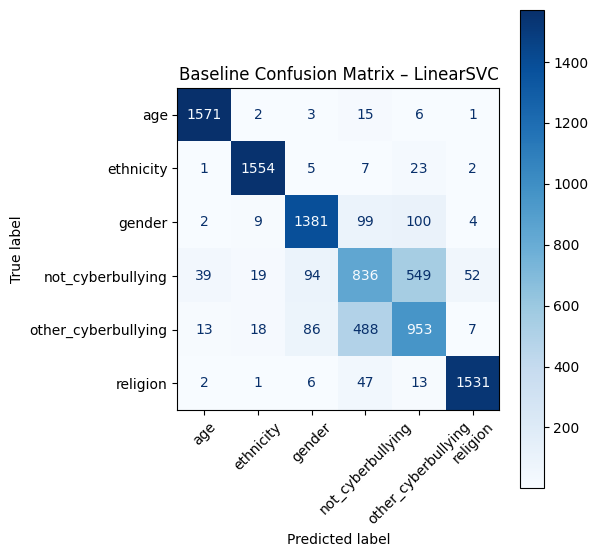


Baseline Confusion Matrix – RandomForest


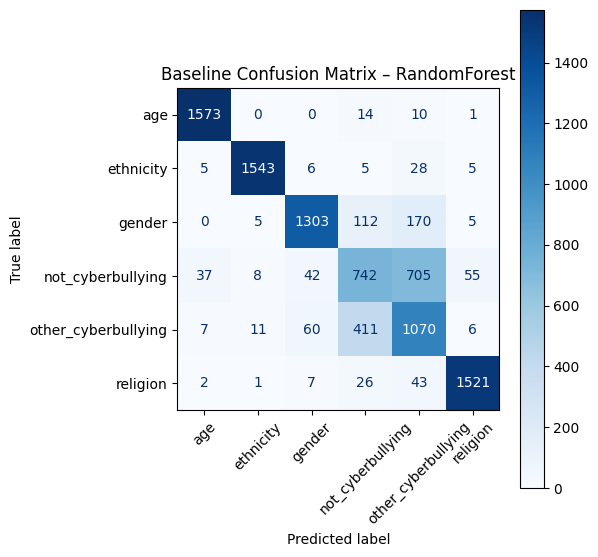


Baseline Confusion Matrix – NaiveBayes


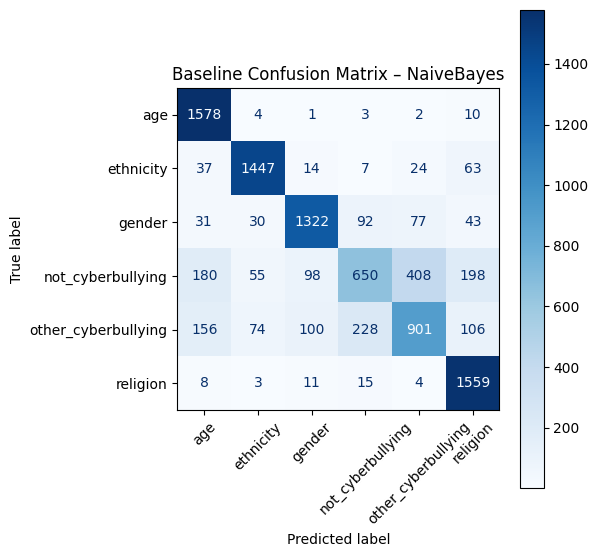


Baseline Confusion Matrix – LogisticRegression


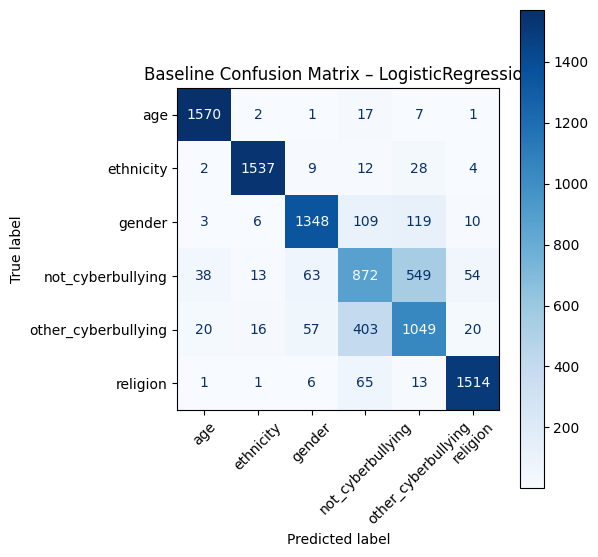

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

classical_models = ["LinearSVC", "RandomForest", "NaiveBayes", "LogisticRegression"]

for model in classical_models:
    if model not in baseline_predictions:
        print(f"⚠️ Skipping {model} (no baseline predictions)")
        continue

    print(f"\nBaseline Confusion Matrix – {model}")

    cm = confusion_matrix(
        y_test,
        baseline_predictions[model]
    )

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=le.classes_
    )

    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    plt.title(f"Baseline Confusion Matrix – {model}")
    plt.tight_layout()
    plt.show()


Confusion Matrix – LinearSVC (Tuned)


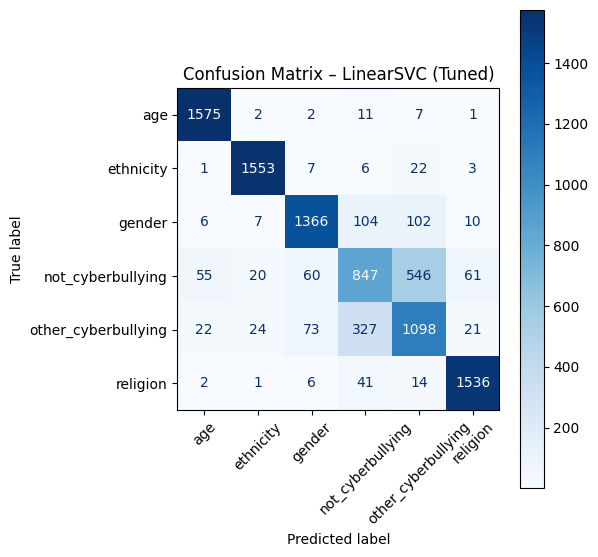


Confusion Matrix – LogisticRegression (Tuned)


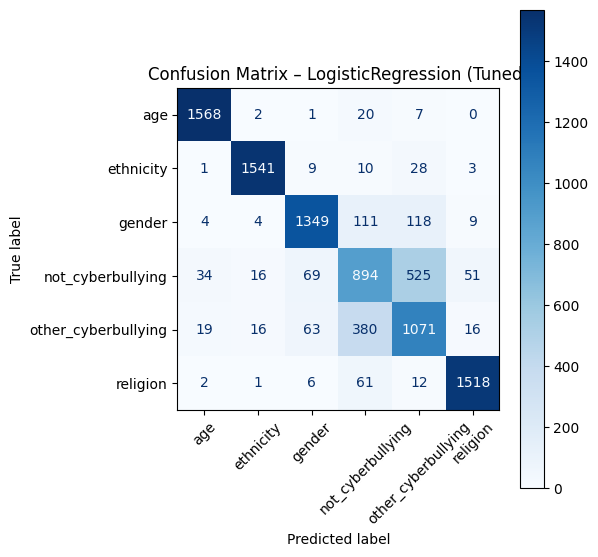


Confusion Matrix – NaiveBayes (Tuned)


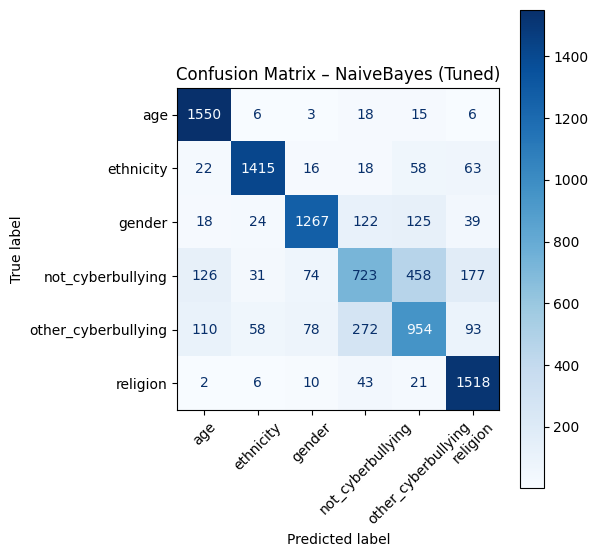


Confusion Matrix – RandomForest (Tuned)


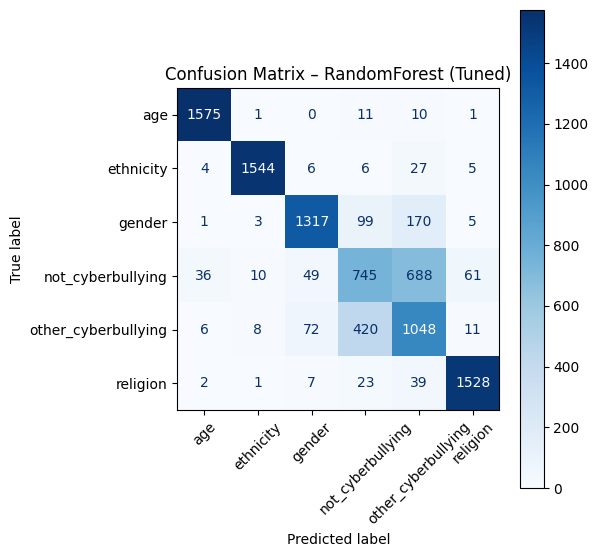

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, y_pred in tuned_predictions.items():
    print(f"\nConfusion Matrix – {name} (Tuned)")

    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=le.classes_
    )

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    plt.title(f"Confusion Matrix – {name} (Tuned)")
    plt.tight_layout()
    plt.show()

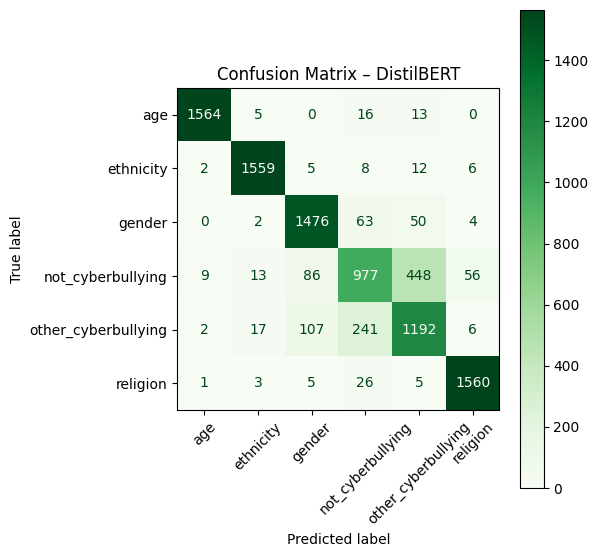

In [40]:
cm_bert = confusion_matrix(
    y_test,
    bert_predictions["DistilBERT"]
)

disp_bert = ConfusionMatrixDisplay(
    confusion_matrix=cm_bert,
    display_labels=le.classes_
)

fig, ax = plt.subplots(figsize=(6,6))
disp_bert.plot(ax=ax, cmap="Greens", xticks_rotation=45)
plt.title("Confusion Matrix – DistilBERT")
plt.tight_layout()
plt.show()